In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import make_pipeline
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestRegressor
import graphviz

# Reading the file

In [3]:
dataset = pd.read_excel('C:\\Users\\dolev\\Documents\\Docs\\Data Science\\Machine-learning\\secend-assesment\\herring_price_train.xlsx')

Now I'd like to understand the shapre of the dataframe

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Feature1   970 non-null    float64
 1   Feature2   970 non-null    float64
 2   Feature3   1000 non-null   object 
 3   Feature4   1000 non-null   object 
 4   Feature5   965 non-null    float64
 5   Feature6   969 non-null    float64
 6   Feature7   971 non-null    float64
 7   Feature8   973 non-null    float64
 8   Feature9   966 non-null    float64
 9   Feature10  965 non-null    float64
 10  Price      1000 non-null   float64
dtypes: float64(9), object(2)
memory usage: 86.1+ KB


In [5]:
dataset.describe(exclude=[object]).T

,count,mean,std,min,25%,50%,75%,max
Feature1,970.0,5.299010,31.986071,1.201504,3.592592,4.253486,4.918534,1000.000000
Feature2,970.0,3.519229,32.269986,-1000.000000,3.865050,4.563057,5.209897,7.738834
Feature5,965.0,5.220990,32.071981,1.287018,3.477981,4.208140,4.855434,1000.000000
Feature6,969.0,4.658473,1.014979,1.511661,3.939879,4.632781,5.361547,7.503020
Feature7,971.0,2.764098,0.586462,2.000528,2.296842,2.638051,3.087333,5.243093
Feature8,973.0,1.780509,32.154383,-1000.000000,2.326696,2.677745,3.169590,5.852731
Feature9,966.0,2.801546,0.611611,2.000207,2.324811,2.652079,3.179404,5.241267
Feature10,965.0,2.812615,0.601790,2.000683,2.330789,2.691908,3.189667,5.926238
Price,1000.0,1059.096071,585.641730,164.392959,628.212162,942.850102,1347.441038,3905.449113


# Checking for outliers 

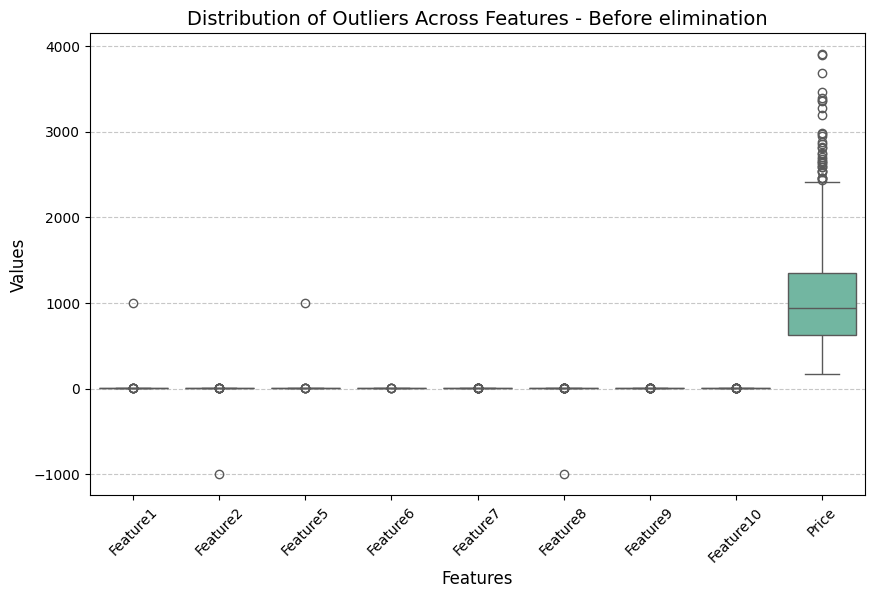

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset, palette="Set2")
plt.title("Distribution of Outliers Across Features - Before elimination", fontsize=14)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Finding Outliers (20% off)

In [7]:
numeric_dataset = dataset.select_dtypes(include=[np.number])
# חישוב Q1, Q3, ו-IQR רק על עמודות מספריות
Q1 = numeric_dataset.quantile(0.10)
Q3 = numeric_dataset.quantile(0.90)
IQR = Q3 - Q1

# תנאי למציאת ערכים קיצוניים
outliers = ((numeric_dataset < (Q1 - 1.5 * IQR)) | (numeric_dataset > (Q3 + 1.5 * IQR)))

# כמה ערכים קיצוניים יש בכל עמודה
outliers_per_column = outliers.sum()

# כמה שורות מכילות לפחות ערך קיצוני אחד
rows_with_outliers = outliers.any(axis=1).sum()

# הצגת המידע
print("כמות הערכים הקיצוניים בכל עמודה:\n", outliers_per_column)
print(f"\nכמות השורות שמכילות לפחות ערך קיצוני אחד: {rows_with_outliers}")

כמות הערכים הקיצוניים בכל עמודה:
 Feature1     1
Feature2     1
Feature5     1
Feature6     0
Feature7     0
Feature8     1
Feature9     0
Feature10    1
Price        2
dtype: int64

כמות השורות שמכילות לפחות ערך קיצוני אחד: 7


## Removing the outliers

In [8]:
# שמירת אינדקסים של השורות המכילות ערכים קיצוניים
rows_to_remove = outliers.any(axis=1)

# הדפסת מספרי השורות להסרה
print("מספרי השורות שיש להסיר (אינדקסים):")
print(dataset.index[rows_to_remove].tolist())


מספרי השורות שיש להסיר (אינדקסים):
[30, 237, 421, 631, 723, 848, 873]


In [9]:
# הסרת השורות המכילות ערכים קיצוניים
dataset_cleaned = dataset[~rows_to_remove]

# הדפסת כמות השורות לאחר הסרה
print(f"\nמספר השורות המקורי: {dataset.shape[0]}")
print(f"מספר השורות לאחר הסרת ערכים קיצוניים: {dataset_cleaned.shape[0]}")
dataset = dataset_cleaned


מספר השורות המקורי: 1000
מספר השורות לאחר הסרת ערכים קיצוניים: 993


In [10]:
#plt.figure(figsize=(10, 6))
#sns.boxplot(data=dataset, palette="Set2")
#plt.title("Distribution of Outliers Across Features - After elimination", fontsize=14)
#plt.xlabel("Features", fontsize=12)
#plt.ylabel("Values", fontsize=12)
#plt.xticks(rotation=45)
#plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.show()

# EDA

## OneHotEncoder
Encoding Feature3 and Feature4 to boolean arry and placing Price in the end of the dataset

In [11]:
# Encoding Feature 3 & Feature 4 columns.
columns_to_encode = ['Feature3', 'Feature4']
encoder = OneHotEncoder(sparse_output=False, drop='if_binary', handle_unknown='ignore')
encoded_features = encoder.fit_transform(dataset[columns_to_encode])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(columns_to_encode))
dataset = dataset.drop(columns=columns_to_encode)
dataset = pd.concat([dataset, encoded_df], axis=1)
column_to_move = 'Price'
# Move the column to the last position
dataset = dataset[[col for col in dataset.columns if col != column_to_move] + [column_to_move]]

dataset.head(2)


,Feature1,Feature2,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature3_A,Feature3_B,Feature3_C,Feature4_House,Price
0,3.838564,2.625122,3.670953,3.509257,2.496714,2.138264,2.647689,3.523030,1.0,0.0,0.0,0.0,604.626580
1,4.058313,3.729892,4.313421,5.426603,2.234153,2.234137,NaN,2.767435,0.0,1.0,0.0,0.0,965.572801


## Filling missing data

In [12]:
# Checking how many lines have nulls inside them
rows_with_nulls = dataset.isnull().any(axis=1).sum()
print(f"Number of rows with at least one null value: {rows_with_nulls}")
imputer = IterativeImputer(max_iter=10, random_state=42)
dataset = pd.DataFrame(imputer.fit_transform(dataset), columns=dataset.columns)

Number of rows with at least one null value: 264


## Heat map Multicollinearity

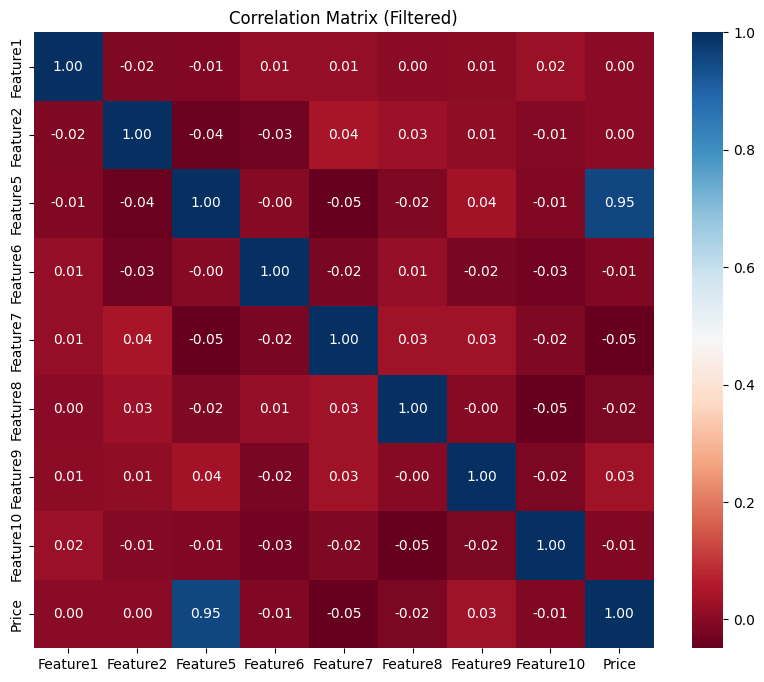

In [13]:
columns_to_remove = ['Feature3_A', 'Feature3_B', 'Feature3_C', 'Feature4_House']
df_filtered = dataset.drop(columns=columns_to_remove)

# Compute the correlation matrix
correlation_matrix = df_filtered.corr()

# Plot the updated heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdBu')
plt.title("Correlation Matrix (Filtered)")
plt.show()

## Variance Inflation Factor (VIF)

In [14]:
# יצירת עותק של הדאטהסט (X) ללא העמודות הבעייתיות
columns_to_exclude = ['Feature3_A', 'Feature3_B', 'Feature3_C', 'Price', 'Feature4_House']
X_filtered = dataset.drop(columns=columns_to_exclude)

# הוספת עמודת קבוע למודל
X_filtered = add_constant(X_filtered)

# חישוב VIF לעמודות שנותרו
vif_data = pd.DataFrame()
vif_data["feature"] = X_filtered.columns
vif_data["VIF"] = [variance_inflation_factor(X_filtered.values, i) for i in range(X_filtered.shape[1])]

print(vif_data)

     feature         VIF
0      const  177.306074
1   Feature1    1.001323
2   Feature2    1.005786
3   Feature5    1.006014
4   Feature6    1.003496
5   Feature7    1.006715
6   Feature8    1.004253
7   Feature9    1.003322
8  Feature10    1.004733


# Linear regrassion

In [15]:
# הפרדת תכונות ויעד מנתוני האימון
X = dataset.iloc[:, :-1].values  # כל העמודות חוץ מהאחרונה
y = dataset.iloc[:, -1].values   # העמודה האחרונה

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize the model
model = LinearRegression()

# 4. Train the model
model.fit(X_train, y_train)

# 5. Make predictions
y_pred = model.predict(X_test)

# 6. Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {round(mae,3)}")
print(f"R^2 Score: {round(r2,3)}")

# Optional: Inspect model coefficients
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {round(model.intercept_,3)}")

Mean Absolute Error: 120.865
R^2 Score: 0.896
Coefficients: [ 6.08934612e+00  2.48685655e+01  5.63941241e+02 -5.35658267e+00
  1.13217116e+01 -2.08325877e+00 -2.16441601e+00 -6.86504842e+00
  9.06502710e+12  9.06502710e+12  9.06502710e+12 -5.43203553e+00]
Intercept: -9065027097526.086


Feature Importance:

           Feature    Importance
10      Feature3_C  9.065027e+12
9       Feature3_B  9.065027e+12
8       Feature3_A  9.065027e+12
2         Feature5  5.639412e+02
1         Feature2  2.486857e+01
4         Feature7  1.132171e+01
7        Feature10  6.865048e+00
0         Feature1  6.089346e+00
11  Feature4_House  5.432036e+00
3         Feature6  5.356583e+00
6         Feature9  2.164416e+00
5         Feature8  2.083259e+00


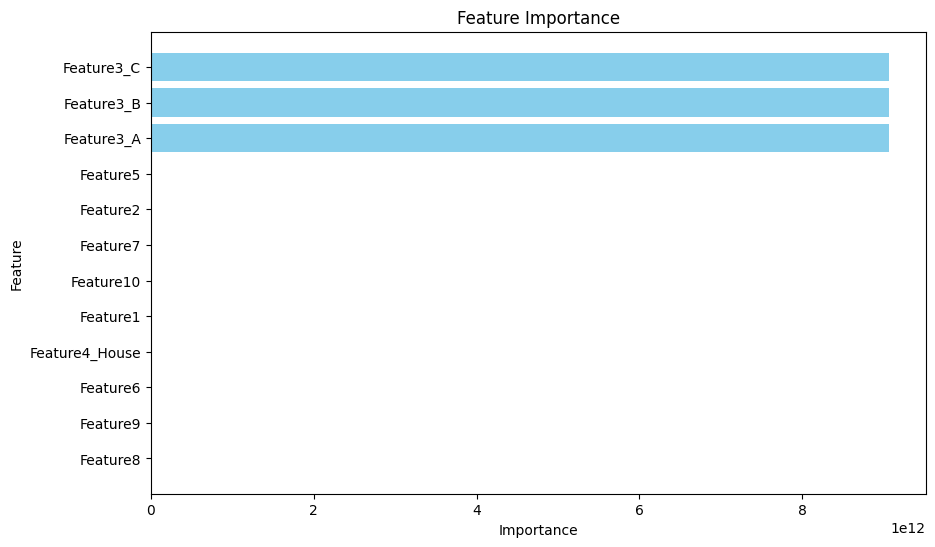

In [16]:

# קבלת שמות הפיצ'רים (אם קיימים)
feature_names = dataset.columns[:-1]  # כל העמודות פרט לעמודת היעד

# קבלת המקדמים המוחלטים
feature_importance = np.abs(model.coef_)

# יצירת טבלה מסודרת
importance_table = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# מיון לפי החשיבות
importance_table = importance_table.sort_values(by='Importance', ascending=False)
print(importance_table)
plt.figure(figsize=(10, 6))
plt.barh(importance_table['Feature'], importance_table['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()


Without boolean features:

Feature Importance Table (Filtered):
           Feature  Importance
2         Feature5  563.941241
1         Feature2   24.868566
4         Feature7   11.321712
7        Feature10    6.865048
0         Feature1    6.089346
11  Feature4_House    5.432036
3         Feature6    5.356583
6         Feature9    2.164416
5         Feature8    2.083259


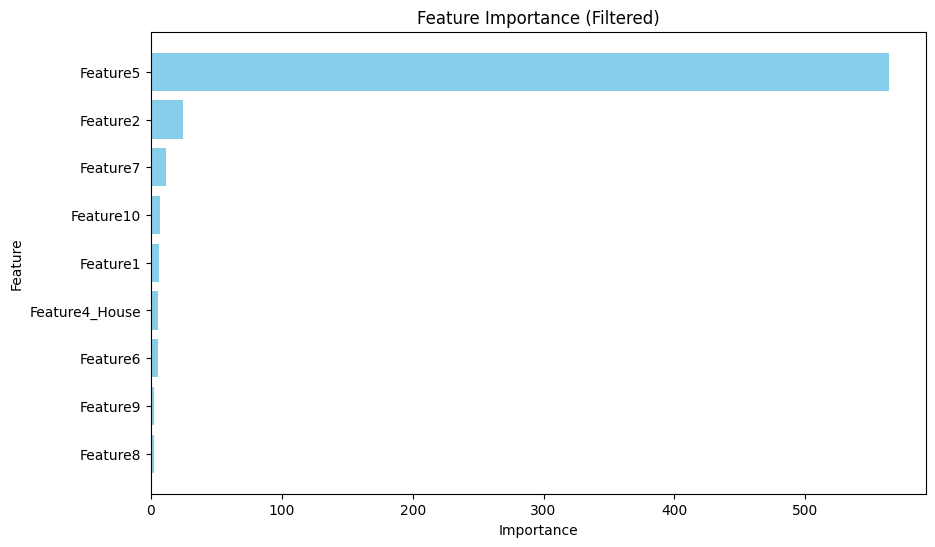

In [17]:

# קבלת שמות הפיצ'רים (אם קיימים)
feature_names = dataset.columns[:-1]  # כל העמודות פרט לעמודת היעד

# קבלת המקדמים המוחלטים
feature_importance = np.abs(model.coef_)

# יצירת טבלה מסודרת
importance_table = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# הסרת הפיצ'רים הלא רלוונטיים
features_to_exclude = ['Feature3_A', 'Feature3_B', 'Feature3_C']
importance_table = importance_table[~importance_table['Feature'].isin(features_to_exclude)]

# מיון לפי החשיבות
importance_table = importance_table.sort_values(by='Importance', ascending=False)

# הצגת טבלת החשיבות
print("Feature Importance Table (Filtered):")
print(importance_table)

# הדמיה של Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_table['Feature'], importance_table['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Filtered)")
plt.gca().invert_yaxis()
plt.show()


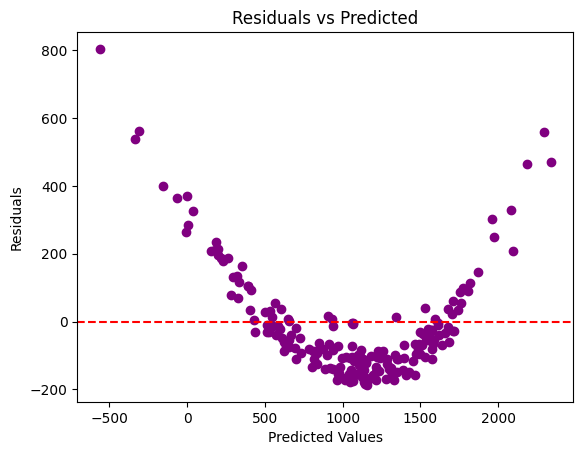

In [18]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()



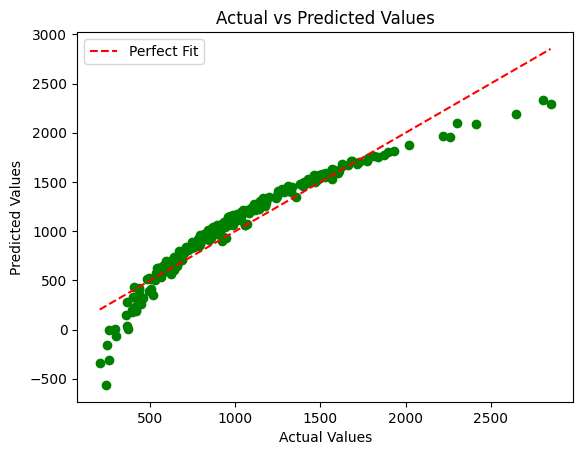

In [19]:
plt.scatter(y_test, y_pred, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Fit')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


# Polynomial regression

In [20]:
# יצירת אובייקט PolynomialFeatures עם מעלה 2 (אפשר לשנות את המעלה בהתאם לצורך)
poly = PolynomialFeatures(degree=2, include_bias=False)

# יצירת Pipeline שמכיל את PolynomialFeatures והרגרסיה הלינארית
poly_model = make_pipeline(poly, LinearRegression())

# אימון המודל עם הנתונים
poly_model.fit(X_train, y_train)

# ביצוע תחזיות
y_poly_pred = poly_model.predict(X_test)

# הערכת המודל
mae_poly = mean_absolute_error(y_test, y_poly_pred)
r2_poly = r2_score(y_test, y_poly_pred)

print(f"Mean Absolute Error (Polynomial Regression): {round(mae_poly, 3)}")
print(f"R^2 Score (Polynomial Regression): {round(r2_poly, 3)}")
print(f"Intercept: {round(model.intercept_,3)}")


Mean Absolute Error (Polynomial Regression): 34.483
R^2 Score (Polynomial Regression): 0.993
Intercept: -9065027097526.086


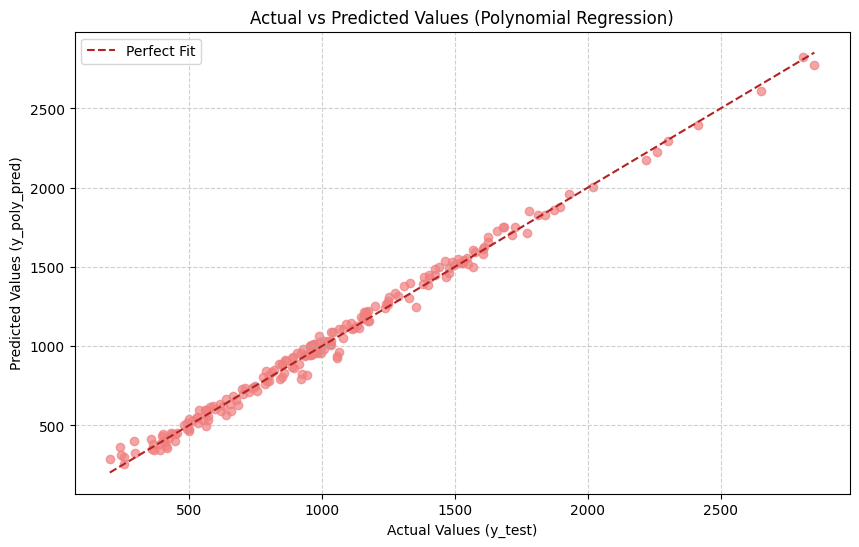

In [21]:
# גרף של Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_poly_pred, alpha=0.7, color='lightcoral')  # נתונים אמיתיים מול חזויים
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='firebrick', linestyle='--', label='Perfect Fit')  # קו התאמה מושלמת
plt.title('Actual vs Predicted Values (Polynomial Regression)')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values (y_poly_pred)')
plt.legend(loc='best', facecolor='white')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



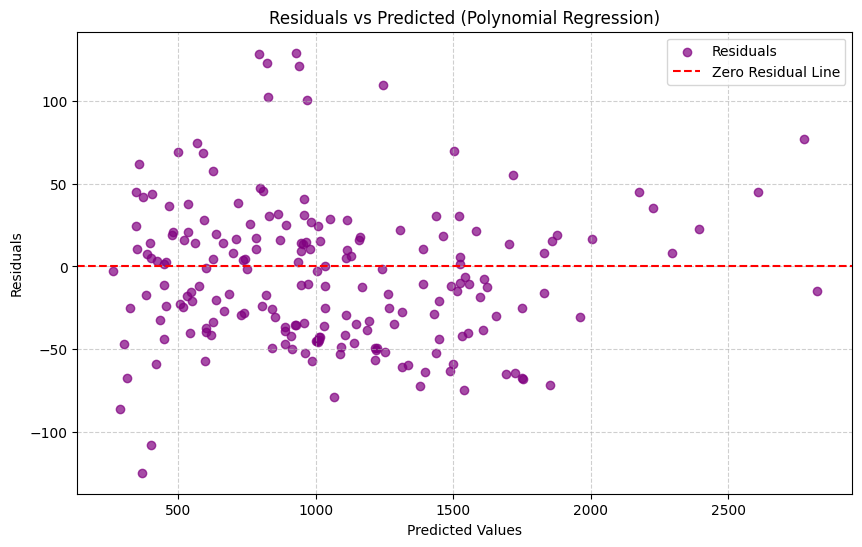

In [22]:
# גרף שאריות
residuals_poly = y_test - y_poly_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_poly_pred, residuals_poly, alpha=0.7, color='purple', label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.title('Residuals vs Predicted (Polynomial Regression)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Feature Importance

                 Feature  Importance
89          feature_12^2  849.752391
11            feature_12  596.588250
2              feature_3  317.855542
84          feature_10^2  246.994616
87          feature_11^2  234.471535
..                   ...         ...
69           feature_7^2    0.431745
15   feature_1 feature_4    0.320286
40   feature_3 feature_8    0.090429
34  feature_2 feature_12    0.089279
48   feature_4 feature_7    0.070184

[90 rows x 2 columns]


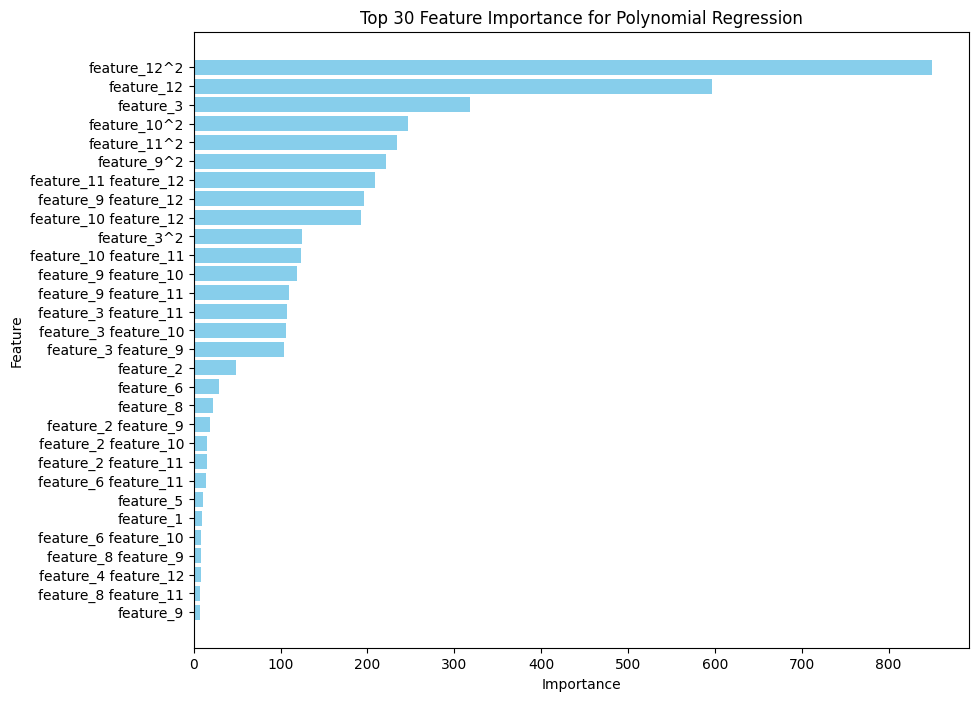

In [23]:
if isinstance(X_train, pd.DataFrame):
    original_feature_names = X_train.columns
else:
    original_feature_names = [f'feature_{i+1}' for i in range(X_train.shape[1])]

poly_features = poly_model.named_steps['polynomialfeatures']
feature_names = poly_features.get_feature_names_out(original_feature_names)

model = poly_model.named_steps['linearregression']
feature_importance = np.abs(model.coef_)

importance_table = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

importance_table = importance_table.sort_values(by='Importance', ascending=False)

print(importance_table)

top_features = importance_table.head(30)

# Create the bar chart
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 30 Feature Importance for Polynomial Regression")
plt.gca().invert_yaxis()
plt.show()

# Decision Tree Regressor

In [24]:
# הנחה: יש לך את dataset
X = dataset.iloc[:, :-1]  # פיצ'רים
y = dataset.iloc[:, -1]   # משתנה המטרה (רציף)

# חלוקת הנתונים לנתוני אימון ובדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# בדיקת עומקים שונים של עץ
max_depths = range(1, 21)  # עומקים מ-1 עד 20
errors = []

for depth in max_depths:
    # יצירת עץ רגרסיה
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    # חישוב MAE על נתוני הבדיקה
    y_pred = tree.predict(X_test)
    errors.append(mean_absolute_error(y_test, y_pred))

# מציאת העומק האופטימלי
optimal_depth = max_depths[np.argmin(errors)]
print(f"Optimal Depth: {optimal_depth}")

# בניית עץ עם העומק האופטימלי
final_tree = DecisionTreeRegressor(max_depth=optimal_depth, random_state=42)
final_tree.fit(X_train, y_train)

# חישוב MAE על נתוני הבדיקה
y_pred_final = final_tree.predict(X_test)
final_mae = mean_absolute_error(y_test, y_pred_final)
print(f"Final Model MAE: {final_mae:.2f}")
r2 = r2_score(y_test, y_pred_final)
print(f"Final R2: {r2}")


Optimal Depth: 5
Final Model MAE: 41.10
Final R2: 0.9898008403735669


In [25]:
# חישוב חשיבות הפיצ'רים
feature_importances = final_tree.feature_importances_

# יצירת טבלה מסודרת לחשיבות הפיצ'רים
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# הצגת התוצאה
print("Feature Importances:")
print(feature_importance_df)


Feature Importances:
           Feature  Importance
2         Feature5    0.999683
1         Feature2    0.000317
0         Feature1    0.000000
3         Feature6    0.000000
4         Feature7    0.000000
5         Feature8    0.000000
6         Feature9    0.000000
7        Feature10    0.000000
8       Feature3_A    0.000000
9       Feature3_B    0.000000
10      Feature3_C    0.000000
11  Feature4_House    0.000000


## Creating Graph 

In [26]:
# ייצוא העץ לפורמט Graphviz
dot_data = export_graphviz(
    final_tree,
    out_file=None,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    special_characters=True
)

# יצירת גרף עם Graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # שומר את העץ לקובץ decision_tree.pdf
graph.view()  # פותח את העץ באופן אוטומטי

'decision_tree.pdf'

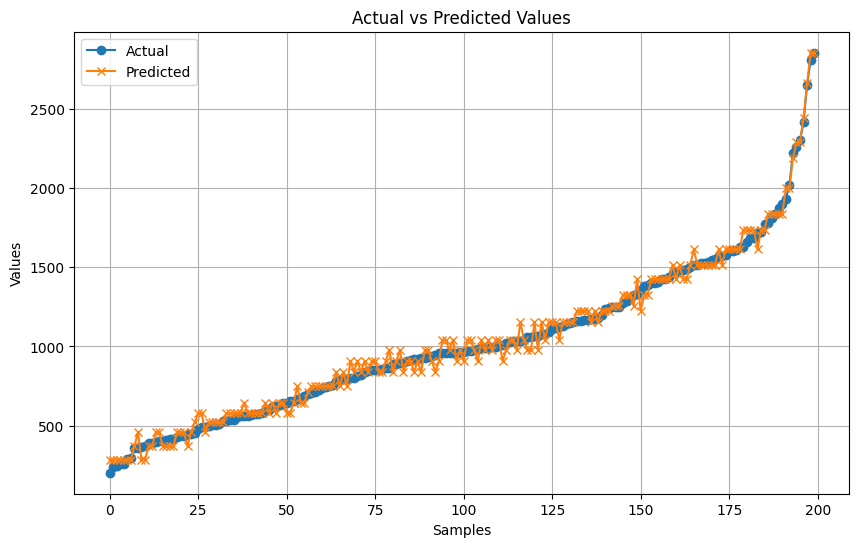

In [27]:
# Actual vs Predicted Values
actual_vs_predicted = pd.DataFrame({"Actual": y_test.values, "Predicted": y_pred_final})
actual_vs_predicted_sorted = actual_vs_predicted.sort_values(by="Actual").reset_index(drop=True)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(actual_vs_predicted_sorted["Actual"], label="Actual", marker='o')
plt.plot(actual_vs_predicted_sorted["Predicted"], label="Predicted", marker='x')
plt.title("Actual vs Predicted Values")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

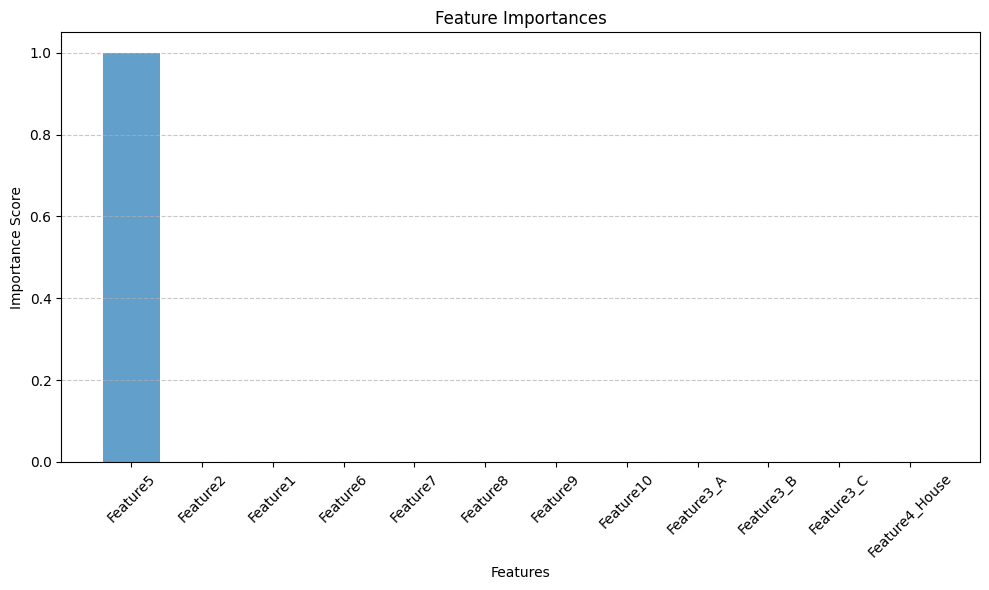

In [28]:
feature_importances = final_tree.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(importance_df["Feature"], importance_df["Importance"], alpha=0.7)
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Random forest

In [29]:
# Define ranges for the number of trees and max depth
n_estimators_range = [1, 10, 20, 30, 40, 50, 60]  # Different numbers of trees
max_depth_range = range(1, 11)  # Max depth from 1 to 9

# Store results
results = []

# Grid search for optimal parameters with minimum samples per split set to 2
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        # Create and fit a Random Forest model
        rf_model = RandomForestRegressor(
            n_estimators=n_estimators, 
            max_depth=max_depth, 
            min_samples_split=2,  # Minimum samples per split set to 2
            random_state=42
        )
        rf_model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred_rf = rf_model.predict(X_test)
        
        # Calculate MAE
        mae = mean_absolute_error(y_test, y_pred_rf)
        
        # Store the parameters and MAE
        results.append({"n_estimators": n_estimators, "max_depth": max_depth, "MAE": mae})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Find the optimal parameters
optimal_params = results_df.loc[results_df["MAE"].idxmin()]
optimal_n_estimators = int(optimal_params["n_estimators"])
optimal_max_depth = int(optimal_params["max_depth"])

# Train the final Random Forest model with optimal parameters
final_rf_model = RandomForestRegressor(
    n_estimators=optimal_n_estimators, 
    max_depth=optimal_max_depth, 
    min_samples_split=3,  
    random_state=42
)
final_rf_model.fit(X_train, y_train)

# Predict on the test set with the final model
y_pred_final_rf = final_rf_model.predict(X_test)

# Calculate the final MAE and R2 score
final_rf_mae = mean_absolute_error(y_test, y_pred_final_rf)
final_rf_r2 = r2_score(y_test, y_pred_final_rf)

# Display optimal parameters and final results
optimal_params, final_rf_mae, final_rf_r2


(n_estimators    40.000000
 max_depth        9.000000
 MAE             32.903321
 Name: 48, dtype: float64,
 32.801916613462204,
 0.9936705159195465)

In [30]:
# חישוב חשיבות הפיצ'רים
feature_importances = final_rf_model.feature_importances_

# יצירת טבלה מסודרת לחשיבות הפיצ'רים
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# הצגת התוצאה
print("Feature Importances:")
print(feature_importance_df)


Feature Importances:
           Feature  Importance
2         Feature5    0.995081
1         Feature2    0.002151
0         Feature1    0.000512
3         Feature6    0.000458
4         Feature7    0.000442
7        Feature10    0.000430
6         Feature9    0.000370
5         Feature8    0.000361
10      Feature3_C    0.000059
11  Feature4_House    0.000056
9       Feature3_B    0.000044
8       Feature3_A    0.000037


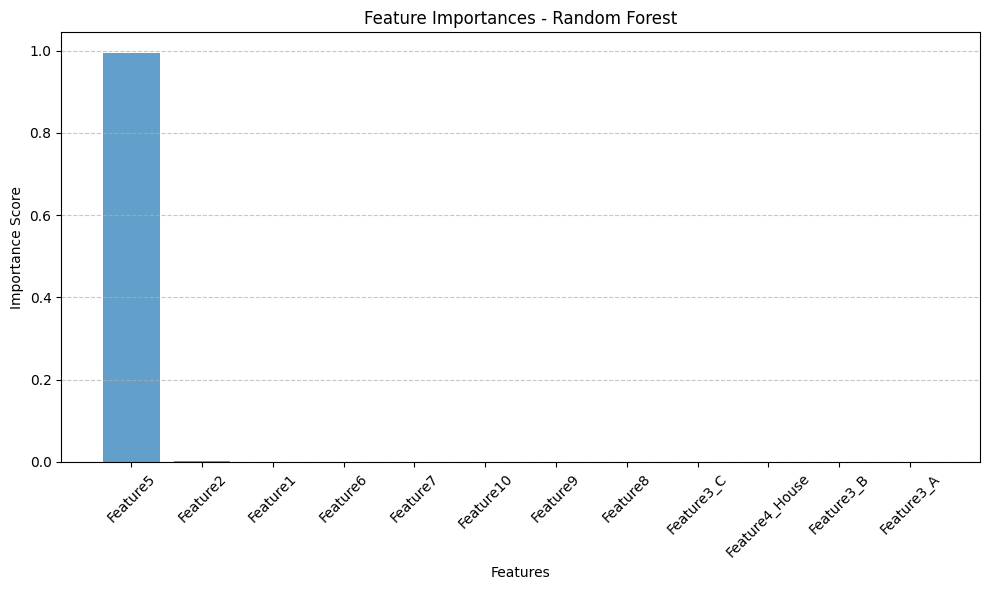

In [31]:
# Get feature importances from the final Random Forest model
rf_feature_importances = final_rf_model.feature_importances_

# Create a DataFrame for better visualization
rf_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_feature_importances
}).sort_values(by="Importance", ascending=False)

# Plot feature importances for the Random Forest model
plt.figure(figsize=(10, 6))
plt.bar(rf_importance_df["Feature"], rf_importance_df["Importance"], alpha=0.7)
plt.title("Feature Importances - Random Forest")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# Prediction the price

In [48]:
pred_df = pd.read_excel('C:\\Users\\dolev\\Documents\\Docs\\Data Science\\Machine-learning\\secend-assesment\\herring_price_test.xlsx')

columns_to_encode = ['Feature3', 'Feature4']

encoder = OneHotEncoder(
    sparse_output=False,
    drop='if_binary',
    handle_unknown='ignore'
)

encoded_features = encoder.fit_transform(pred_df[columns_to_encode])
encoded_df = pd.DataFrame(
    encoded_features,
    columns=encoder.get_feature_names_out(columns_to_encode),
    index=pred_df.index
)

# מסירים את העמודות המקוריות ומוסיפים את עמודות ה-OHE
pred_df.drop(columns=columns_to_encode, inplace=True)
pred_df = pd.concat([pred_df, encoded_df], axis=1)

# ======== שלב 3: חיזוי עם המודל ========
# מפרידים את Price
X_pred = pred_df.drop("Price", axis=1)

# מנבאים
predictions = final_rf_model.predict(X_pred)

# מחזירים את ערכי החיזוי לעמודת Price
pred_df["Price"] = predictions

# ======== שלב 4: שיחזור (Decoding) של העמודות שהוצפנו ========
# מזהים את כל העמודות שנוצרו ע"י ה-Encoder
ohe_cols = encoder.get_feature_names_out(columns_to_encode)

# inverse_transform על העמודות הבינאריות בלבד
decoded_array = encoder.inverse_transform(pred_df[ohe_cols])
decoded_df = pd.DataFrame(decoded_array, columns=columns_to_encode, index=pred_df.index)

# מסירים את עמודות ה-OHE
pred_df.drop(columns=ohe_cols, inplace=True)

# מחדירים (insert) את העמודות המשוחזרות למיקומים הרצויים (אינדקס 2 ו-3)
pred_df.insert(2, 'Feature3', decoded_df['Feature3'])
pred_df.insert(3, 'Feature4', decoded_df['Feature4'])

# ======== שלב 5: שמירת התוצאה לקובץ Excel חדש ========
pred_df.to_excel("herring_price_test.xlsx", index=False)

print("Finish. File saved as 'herring_price_test.xlsx'")

Finish. File saved as 'herring_price_test.xlsx'
